In [5]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------#
# --------------------Plots----------------------#
# -----------------------------------------------#
def match_combo(row):
    if row["Filename_Match"] and row["Page_Match"]:
        return "File and Page"
    elif row["Filename_Match"]:
        return "Filename Only"
    elif row["Page_Match"]:
        return "Page Only"
    else:
        return "Neither"
    
def plot_acc_by_cat(df):
    df_counts = df.groupby(['Category', 'Match_Threshold']).size().unstack(fill_value=0)
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(16, 8))

    categories = df_counts.index
    true_counts = df_counts[True] if True in df_counts else [0]*len(categories)
    false_counts = df_counts[False] if False in df_counts else [0]*len(categories)

    plt.bar(categories, false_counts, label='False', color='salmon')
    plt.bar(categories, true_counts, bottom=false_counts, label='True', color='seagreen')

    plt.title("Match Threshold Accuracy by Category")
    plt.ylabel("Count of Matches above threshold")
    plt.xticks(rotation=45)
    plt.legend(title="Match Threshold")
    plt.tight_layout()
    plt.show()
    
    
def plot_match_by_diff(df):
    counts = df.groupby(['Difficulty', 'Match_Threshold']).size().unstack(fill_value=0)

    difficulties = counts.index
    false_counts = counts[False] if False in counts else [0]*len(difficulties)
    true_counts = counts[True] if True in counts else [0]*len(difficulties)

    plt.figure(figsize=(8, 6))
    plt.bar(difficulties, false_counts, label='Match_Threshold = False', color='salmon')
    plt.bar(difficulties, true_counts, bottom=false_counts, label='Match_Threshold = True', color='seagreen')

    plt.title("Match Threshold Count by Difficulty")
    plt.ylabel("Count")
    plt.xlabel("Difficulty")
    plt.legend(title="Match_Threshold")
    plt.tight_layout()
    plt.show()
    
def plot_match_file_vs_page(df):
    df["Match_Combo"] = df["Filename_Match"].astype(str) + "File_" + df["Page_Match"].astype(str) + "Page"

    # Plot
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x="Match_Combo", order=df["Match_Combo"].value_counts().index, hue="Match_Combo")

    plt.title("Combined Filename and Page Match")
    plt.xlabel("Match Combination (Filename_Page)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    
def plot_threshold_given_page_match(df):
    filtered_df = df[df["Page_Match"]]
    threshold_counts = filtered_df["Match_Threshold"].value_counts().reindex([True, False], fill_value=0)

    plt.figure(figsize=(6, 5))
    plt.bar(threshold_counts.index.map(str), threshold_counts.values, color=['seagreen', 'salmon'])

    plt.title("Match Threshold Counts (Only Where Page Match = True)")
    plt.xlabel("Match_Threshold")
    plt.ylabel("Count")
    plt.xticks([0, 1], ["False", "True"])
    plt.tight_layout()
    plt.show()
    

def plot_best_result_by_text_match(df):
    df["Combined_Score"] = df["Text_Match_Start_Percent"] + df["Text_Match_End_Percent"]
    df["Result_Tag"] = df["Result_Id"].str[-2:]
    df["Question_Id"] = df["Result_Id"].str[:-2]
    best_results = df.loc[df.groupby("Question_Id")["Combined_Score"].idxmax()]
    result_counts = best_results["Result_Tag"].value_counts().reindex(["R1", "R2", "R3", "R4", "R5"], fill_value=0)

    plt.figure(figsize=(6, 5))
    plt.bar(result_counts.index, result_counts.values, color="cornflowerblue")
    plt.title("Best Result Based on Combined Text Match")
    plt.xlabel("Result (R1, R2, R3, R4, R5)")
    plt.ylabel("Number of Times Best")
    plt.tight_layout()
    plt.show()
    

def plot_matches_heatmap_split(df):
    g = sns.FacetGrid(df, col="Match_Threshold", height=6, aspect=1)
    g.map_dataframe(
        sns.histplot,
        x="Text_Match_End_Percent",
        y="Text_Match_Start_Percent",
        bins=30,
        cmap="coolwarm",
        cbar=True
    )
    g.set_axis_labels("Text Match from End (%)", "Text Match from Start (%)")
    g.figure.subplots_adjust(top=0.85)
    g.figure.suptitle("Heatmap of Text Match Start vs End (%) by Threshold")
    plt.show()

def plot_accuracy_precision_recall(df):
    df['Query_ID'] = df['Result_Id'].str[:-2]
    
    # Compute Accuracy (regardless of Distance)
    accuracy_df = df.groupby('Query_ID')['Filename_Match'].any()
    accuracy = accuracy_df.mean()
    print(f"Accuracy: {accuracy:.2f}")

    # Filter by Distance (Random chpice of 0.8, we should think abot this)
    filtered_df = df[df['Distance'] <= 0.8]

    # Precision calculation
    # Get matches after filtering
    matches_after_filter = filtered_df.groupby('Query_ID')['Filename_Match'].any()

    # Total queries with results after filtering
    queries_with_results = filtered_df['Query_ID'].unique()

    # Precision = matched queries / total queries with results
    precision = matches_after_filter.sum() / len(queries_with_results)
    print(f"Precision: {precision:.2f}")

    # Recall calculation
    # Find all query IDs (with and without results)
    all_queries = df['Query_ID'].unique()

    # Find queries with no results after filtering
    queries_with_no_results = set(all_queries) - set(queries_with_results)
    
    # Recall = matched queries / (matched queries + queries with no results)
    recall = matches_after_filter.sum() / (matches_after_filter.sum() + len(queries_with_no_results))
    print(f"Recall: {recall:.2f}")
    print("Queries with results after filtering:", len(queries_with_results))
    print("Queries with no results after filtering:", len(queries_with_no_results))
    print("Total number of queries:", len(all_queries))

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall], color=['blue', 'green', 'orange'])
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title('Evaluation Metrics')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()



def plot_match_file_vs_page_by_result(df):
    # Extract Result Number (e.g., R1, R2, ..., R5)
    df["Result_Num"] = df["Result_Id"].str.extract(r'(R[1-5])')

    # Create combined match string
    df["Match_Combo"] = df["Filename_Match"].astype(str) + "_File_" + df["Page_Match"].astype(str) + "_Page"

    # Plot
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x="Match_Combo", order=df["Match_Combo"].value_counts().index, hue="Result_Num")

    plt.title("Filename and Page Matches by Result Number")
    plt.xlabel("Match Combination (Filename_Page)")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Result Number")
    plt.tight_layout()
    plt.show()
    
def plot_match_file_vs_page_by_result2(df):
    # Extract Result Number (R1–R5) from Result_Id
    df["Result_Num"] = df["Result_Id"].str.extract(r'(R[1-5])')

    # Combine Filename and Page into one string
    df["Match_Combo"] = df["Filename_Match"].astype(str) + "_File_" + df["Page_Match"].astype(str) + "_Page"

    # Initialize FacetGrid with one subplot per result number
    g = sns.FacetGrid(df, col="Result_Num", col_order=["R1", "R2", "R3", "R4", "R5"], 
                      col_wrap=3, height=4, sharex=False, sharey=True)

    # Map countplot onto each subplot
    g.map(sns.countplot, "Match_Combo", order=df["Match_Combo"].value_counts().index)
    
    # Adjust plot aesthetics
    g.set_titles("Result: {col_name}")
    for ax in g.axes.flat:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    g.set_axis_labels("Match Combination (Filename_Page)", "Count")

    plt.tight_layout()
    plt.show()
    
def plot_matches_heatmap_split_with_match_type(df):
    # Ensure Match_Combo and Match_Type columns are present
    df["Match_Combo"] = df.apply(match_combo, axis=1)
    size_map = {
        "File and Page": 200,
        "Filename Only": 150,
        "Page Only": 100,
        "Neither": 50
    }
    color_map = {
        "File and Page": "pink",
        "Filename Only": "blue",
        "Page Only": "yellow",
        "Neither": "red"
    }
    df["Match_Type"] = df["Match_Combo"].map(lambda x: {
        "File and Page": "File and Page",
        "Filename Only": "Filename Only",
        "Page Only": "Page Only",
        "Neither": "Neither"
    }[x])
    df["Point_Size"] = df["Match_Type"].map(size_map)
    df["Point_Color"] = df["Match_Type"].map(color_map)

    g = sns.FacetGrid(df, col="Match_Threshold", height=6, aspect=1)
    g.map_dataframe(
        sns.scatterplot,
        x="Text_Match_End_Percent",
        y="Text_Match_Start_Percent",
        hue="Match_Type",
        size="Point_Size",
        sizes=(50, 200),
        alpha=0.6,
        palette=color_map,
        legend="full"
    )
    
    g.set_axis_labels("Text Match from End (%)", "Text Match from Start (%)")
    g.figure.subplots_adjust(top=0.85)
    g.figure.suptitle("Match Type Scatter Heatmap by Threshold")
    g.add_legend(title="Match Type")

    plt.show()  

In [6]:
df = pd.read_csv("../../results/norm_queries_no_tol.csv", sep=",", encoding="utf-8")

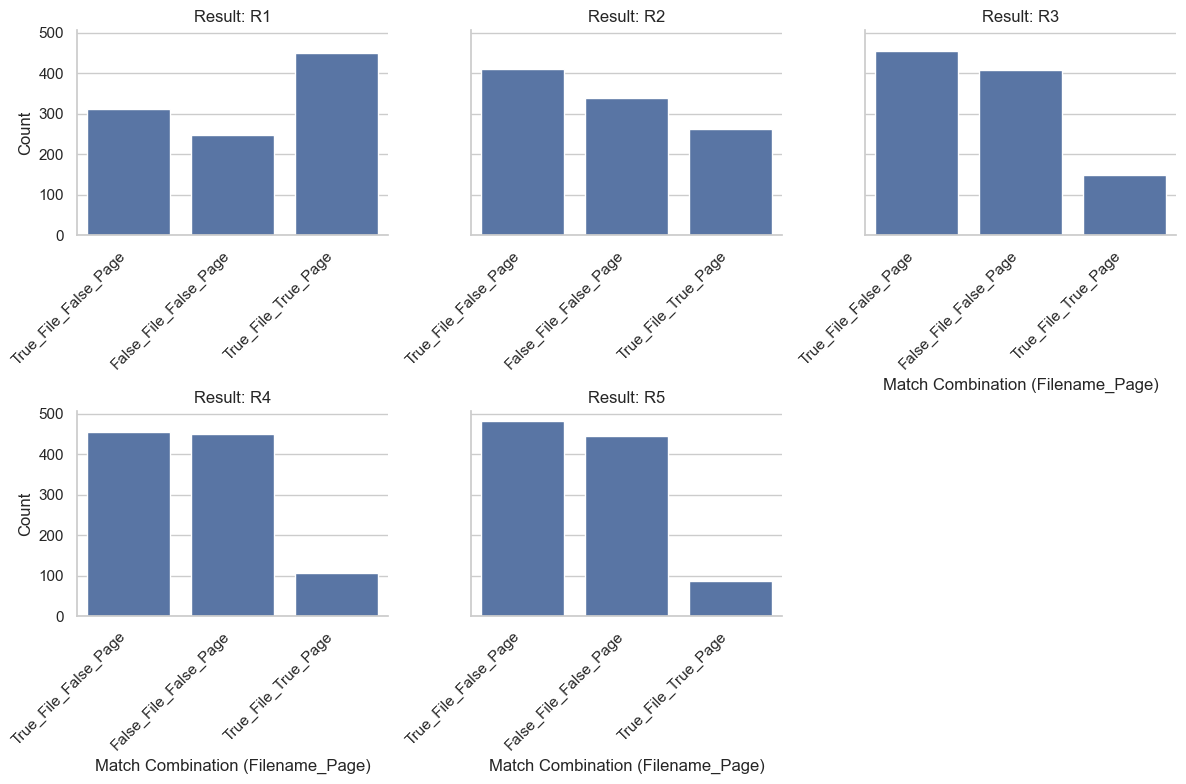

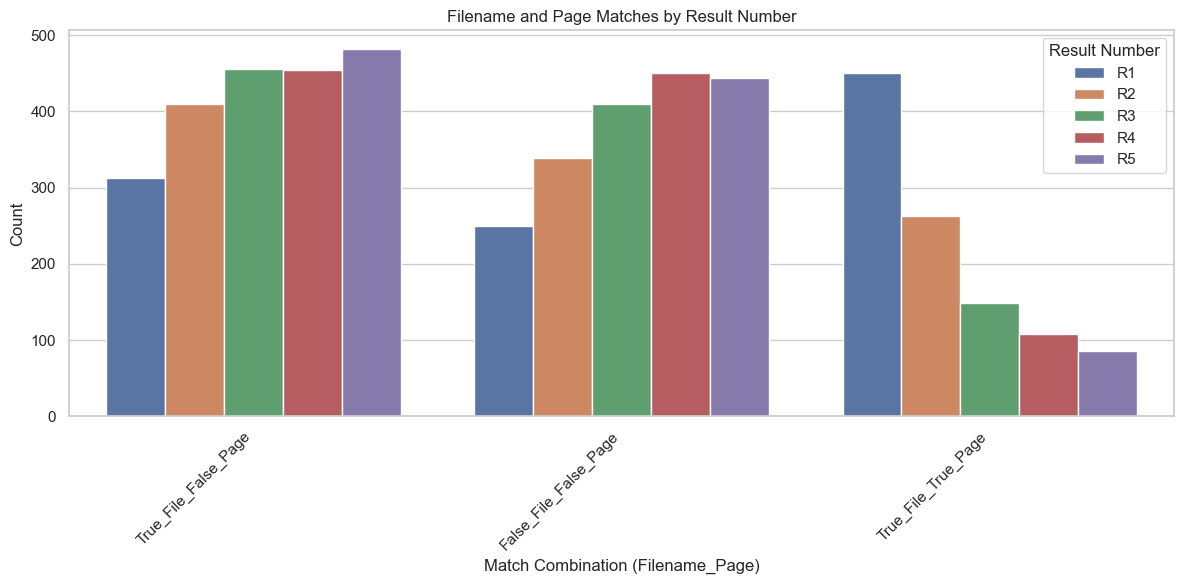

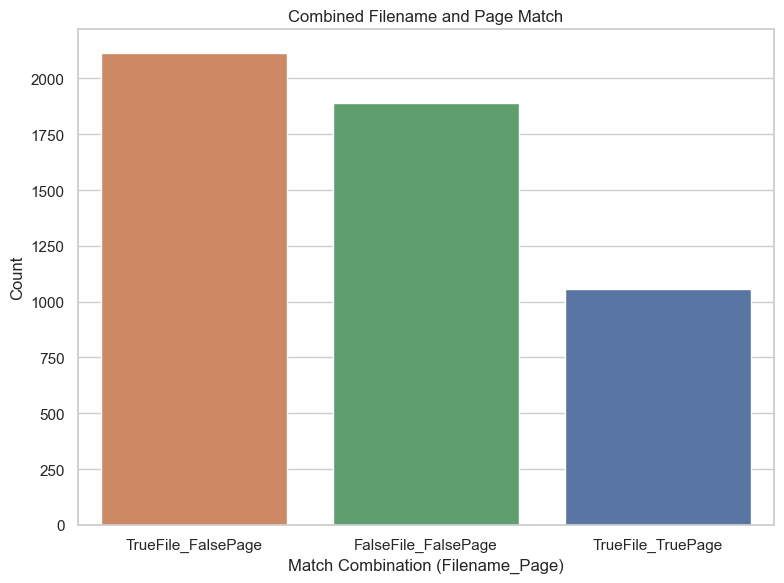

Accuracy: 0.87
Precision: 0.91
Recall: 0.73
Queries with results after filtering: 756
Queries with no results after filtering: 256
Total number of queries: 1012


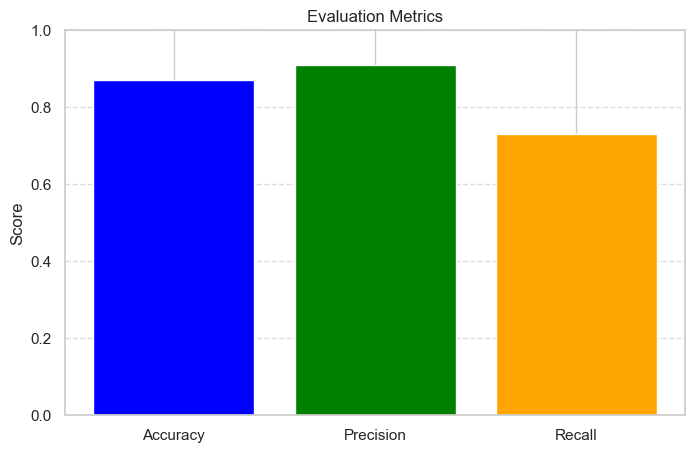

In [8]:
plot_match_file_vs_page_by_result2(df)
plot_match_file_vs_page_by_result(df)
plot_match_file_vs_page(df)
plot_accuracy_precision_recall(df)

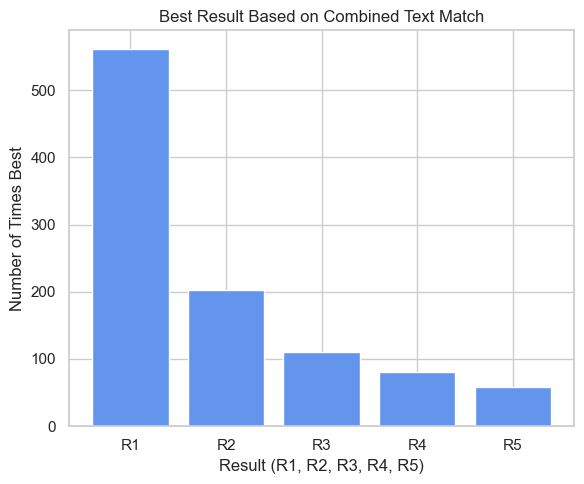

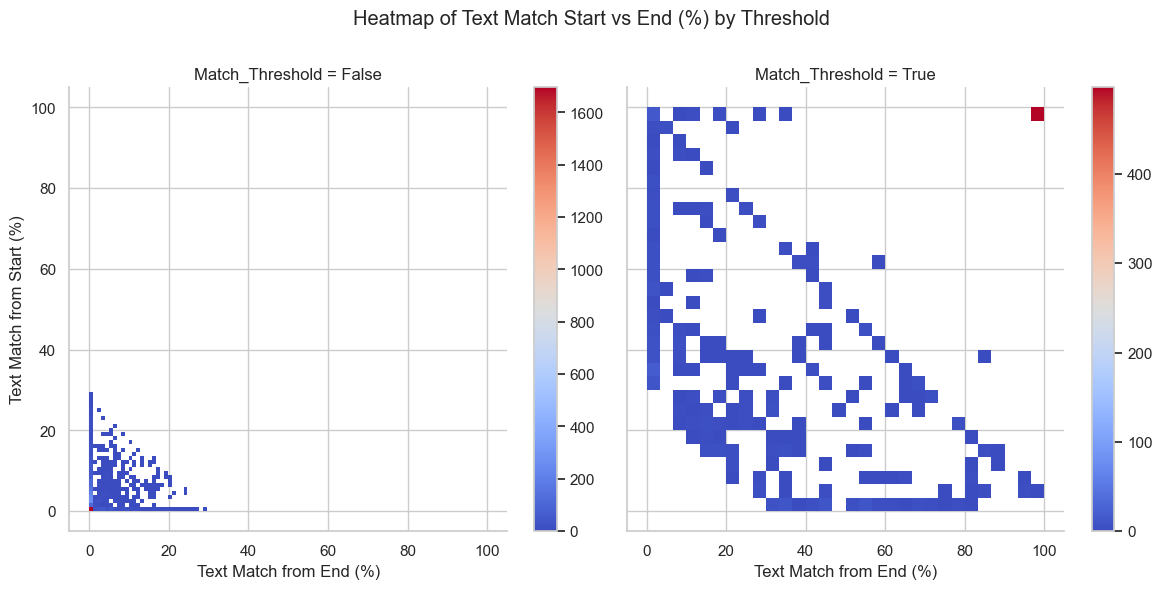

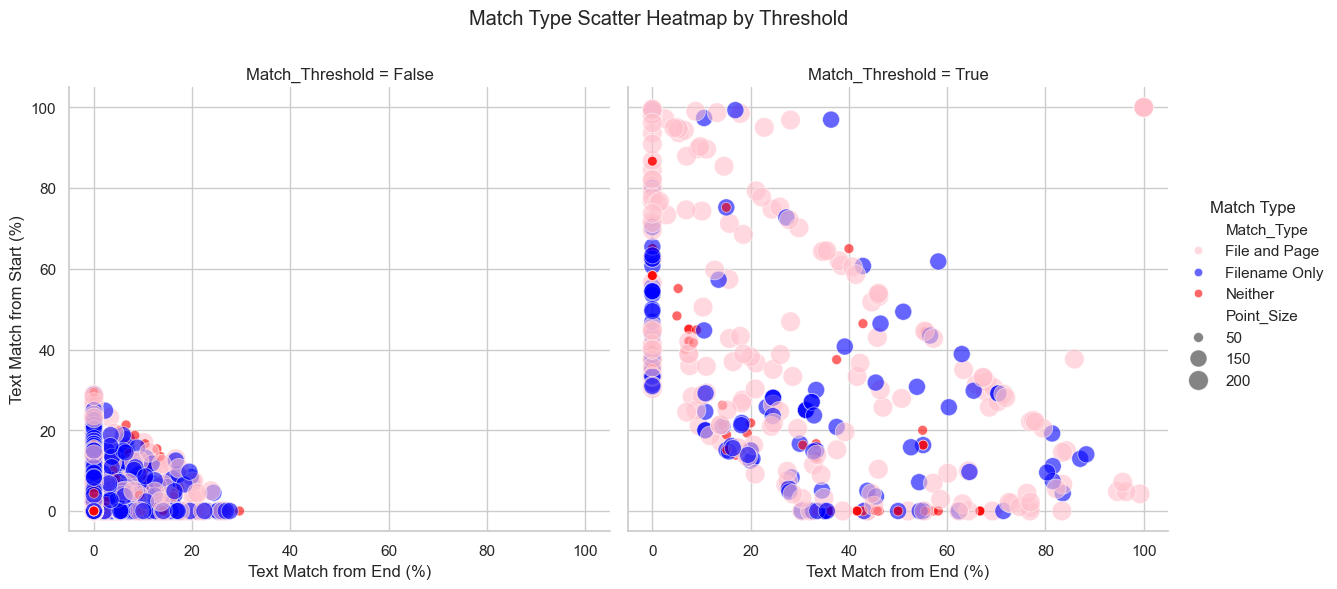

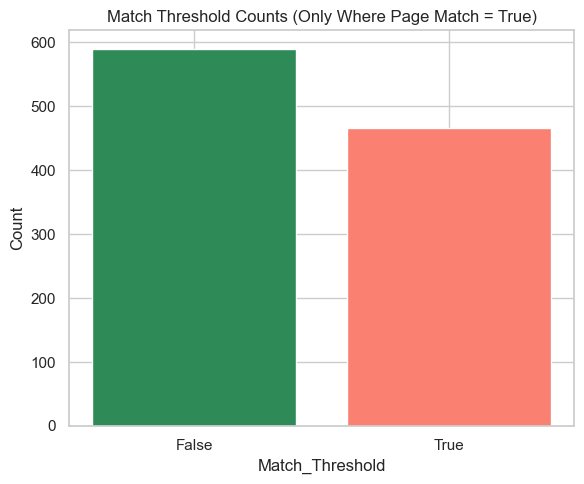

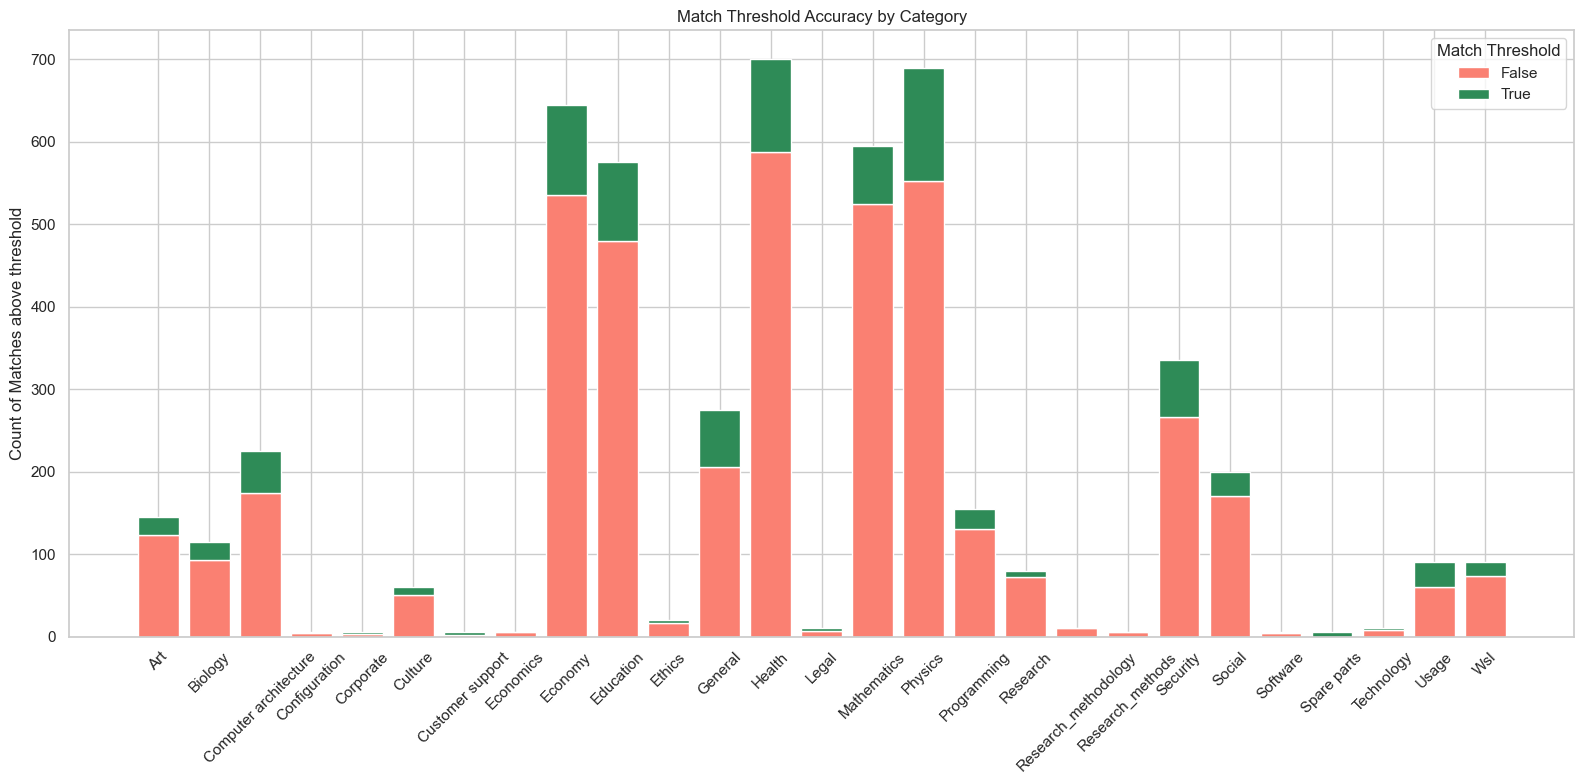

In [10]:
plot_best_result_by_text_match(df)
plot_matches_heatmap_split(df)
plot_matches_heatmap_split_with_match_type(df)
plot_threshold_given_page_match(df)
plot_acc_by_cat(df)